In [1]:
!pip install virtualenv
!virtualenv XAIEnv

created virtual environment CPython3.10.10.final.0-64 in 1669ms
  creator CPython3Posix(dest=/kaggle/working/XAIEnv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==23.0.1, setuptools==67.4.0, wheel==0.38.4
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


# Explain Classification result from ResNet

In [2]:
%%time
!source /kaggle/working/XAIEnv/bin/activate; pip install -q numba torch captum torchvision quantus omnixai[vision] dash jupyter_dash dash_bootstrap_components scikit-learn==1.1.3 numpy==1.22.4 Pillow fastcore -U


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
CPU times: user 2.57 s, sys: 398 ms, total: 2.97 s
Wall time: 3min 33s


In [3]:
import sys
sys.path.append("XAIEnv/lib/python3.10/site-packages")

In [4]:
import torch
# import quantus
from captum.attr import (
    Saliency, # A baseline approach for computing input attribution
    GradientShap, 
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
    GuidedGradCam,
    GuidedBackprop,
    Saliency,
    LimeBase,
    FeatureAblation,
    Occlusion,
    LRP,
    visualization as viz,
    Lime
)
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso
from captum.attr._core.lime import get_exp_kernel_similarity_function
from PIL import Image
import torchvision
from torchvision import transforms
import json
import requests
from io import BytesIO
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
from torchvision import models
import seaborn as sns
import scipy
import skimage
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
warnings.filterwarnings('ignore')
import gc
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
cpu = torch.device("cpu")
print(f'Using {device} for inference')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using cuda for inference


In [5]:
torch.manual_seed(123)
np.random.seed(123)

# Setup datasets and configurations

In [6]:
USE_KAGGLE = True

# Dataset
KAGGLE_DATASET_PATH = '/kaggle/input/pneumothorax-chest-xray-images-and-masks'
COLAB_DATASET_PATH = '/content/datasets'
DATASET_PATH = KAGGLE_DATASET_PATH if USE_KAGGLE else COLAB_DATASET_PATH

# Checkpoint
KAGGLE_CHECKPOINT_PATH = '/kaggle/input/xai-pretrained-blackbox'
COLAB_CHECKPOINT_PATH = '/content/datasets/'

CHECKPOINT_PATH = KAGGLE_CHECKPOINT_PATH if USE_KAGGLE else COLAB_CHECKPOINT_PATH

In [7]:
INPUT_SIZE = (128, 128)
RUN_ON_TEST_SET_SAMPLE = True

In [8]:
resize_image = transforms.Compose([
  transforms.Resize(INPUT_SIZE),
#   transforms.CenterCrop(299),
])

transform = transforms.Compose([            
  transforms.ToTensor(),
  resize_image,
  transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
  )
])

mask_transform = transforms.Compose([            
  transforms.ToTensor(),
  resize_image,
])

In [9]:
from torch.utils.data import Dataset

class PneumothoraxImageDataset(Dataset):
    def __init__(self, images, targets, masks, transform, mask_transform):
        self.masks = masks
        self.images = images
        self.targets = targets
        self.transform = transform
        self.mask_transform = mask_transform
        

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = np.asarray(Image.open(self.images[idx]).convert('RGB'))
        mask = np.asarray(Image.open(self.masks[idx]).convert('RGB'))
        label = self.targets[idx]
        if self.transform:
          image = self.transform(image)
        if self.mask_transform:
          mask = self.mask_transform(mask)
        return image, mask, label

In [10]:
import os
import pandas as pd
# train_data = pd.read_csv(os.path.join(main_path, 'stage_1_train_images.csv'))
DATASET_NAME = 'siim-acr-pneumothorax'
test_data = pd.read_csv(os.path.join(DATASET_PATH, DATASET_NAME, 'stage_1_test_images.csv'))
# Just load only abnormal cases
# test_abnormal = test_data.loc[test_data.has_pneumo == 1]

# Load all cases
test_abnormal = test_data

# train_data['images'] = train_data['new_filename'].apply(lambda x: os.path.join(main_path, 'png_images', x))
# train_data['masks'] = train_data['new_filename'].apply(lambda x: os.path.join(main_path, 'png_masks', x))

test_abnormal['images'] = test_abnormal['new_filename'].apply(lambda x: os.path.join(DATASET_PATH, DATASET_NAME, 'png_images', x))
test_abnormal['masks'] = test_abnormal['new_filename'].apply(lambda x: os.path.join(DATASET_PATH, DATASET_NAME, 'png_masks', x))

images = test_abnormal['images'].tolist()
masks = test_abnormal['masks'].tolist()
targets = test_abnormal['has_pneumo'].tolist()

In [11]:
dataset = PneumothoraxImageDataset(images, targets, masks, transform=transform, mask_transform=mask_transform)
ds_loader = torch.utils.data.DataLoader(dataset, batch_size=16, num_workers=4, shuffle=RUN_ON_TEST_SET_SAMPLE)

## Setup Blackbox & XAI methods

In [12]:
# ResNet
resnet_cp = torch.load(f'{CHECKPOINT_PATH}/resnet_cp.pth')
blackbox_resnet = models.resnet101()
blackbox_resnet.load_state_dict(resnet_cp)
for param in blackbox_resnet.parameters():
    param.require_grad = False
blackbox_resnet = torch.nn.DataParallel(blackbox_resnet.cuda())
blackbox_resnet = blackbox_resnet.eval().to(device)

# InceptionV3
checkpoint = torch.load(f'{CHECKPOINT_PATH}/inception_cp.pth')
blackbox_inception = models.inception_v3()
blackbox_inception.load_state_dict(checkpoint)
for parameter in blackbox_inception.parameters():
    parameter.requires_grad = False
blackbox_inception = torch.nn.DataParallel(blackbox_inception.cuda())
blackbox_inception = blackbox_inception.eval().to(device)


In [13]:
blackbox_configs = {
    'ResNet': {
        'module': blackbox_resnet,
        'layer_name_for_guided_gc': 'layer4'
    },
    'InceptionV3': {
        'module': blackbox_inception,
        'layer_name_for_guided_gc': 'Mixed_7c'
    }
}


blackbox_selected = 'InceptionV3'
blackbox = blackbox_configs[blackbox_selected]['module']
layer = getattr(blackbox.module, blackbox_configs[blackbox_selected]['layer_name_for_guided_gc'])

In [14]:
class ScalarOutputWrapper(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.m = module
    
    def forward(self, x):
        output = self.m(x)
        _, res = torch.topk(output, 1, dim=1)
        return res

In [15]:
sl = Saliency(blackbox)
guided_gc = GuidedGradCam(blackbox, layer)
gbp = GuidedBackprop(blackbox)
lrp = LRP(blackbox)
dls = DeepLiftShap(blackbox)
dl = DeepLift(blackbox)
gs = GradientShap(blackbox)
ig = IntegratedGradients(blackbox)
ablator = FeatureAblation(blackbox)
occlusion = Occlusion(blackbox)
smoothgrad = NoiseTunnel(ig)

# Generate Explanations

In [16]:
# wrapper = ScalarOutputWrapper(blackbox)
# lime = Lime(wrapper, interpretable_model=SkLearnLinearRegression(), similarity_func=get_exp_kernel_similarity_function('euclidean', kernel_width=1000))

In [17]:
rand_img_dist = torch.rand((1, 3, 128, 128)).to(device)
rand_img_dist.shape

torch.Size([1, 3, 128, 128])

In [18]:
dataset_labels = { 0: 'normal', 1: 'Pneumothorax' }

In [19]:
xai_methods = {
  "Saliency": { "method": sl , "options": {}},
  "GuidedGradCam": { "method": guided_gc, "options": {'interpolate_mode': 'area'}},
  "GuidedBackprop": { "method": gbp, "options": {}},
  "LRP": { "method": lrp, "options": {}},
  # "DeepLiftShap": { "method": dls, "options": {}},
  # "DeepLift": { "method": dl, "options": {}},
  "GradientShap": { "method": gs, "options": { 'n_samples': 16, 'stdevs': 0.0001, 'baselines': rand_img_dist }},
  "IntegratedGradients": { "method": ig, "options": { 'n_steps' : 100, 'internal_batch_size': 1 }, 'baselines': rand_img_dist },
  # "FeatureAblation": { "method": ablator, "options": {}},
  "Occlusion": { "method": occlusion, "options": { 'sliding_window_shapes': (3,8, 8), 'strides': (3, 4, 4)}},
  "SmoothGrad": {"method": smoothgrad, "options": {"nt_type": "smoothgrad"}}
}

In [20]:
from tqdm import tqdm
import gc

def visualize_explain_of(xai_methods, x, mask, y, blackbox):
  with torch.no_grad():
    output = torch.nn.functional.softmax(blackbox(x), dim=1)
    _, indices = torch.topk(output, k=1, dim = 1)
  indices = torch.flatten(indices)
  num_methods = len(xai_methods.items())
  for idx, img in tqdm(enumerate(x)):
    target = indices[idx]
    if target.item() == 0:
      continue
    fig, axes = plt.subplots(1, num_methods + 1, figsize = (48, 6))
    axes[0].imshow(np.transpose(mask[idx].detach().numpy(), (1, 2, 0)))
    for method_idx, (method_name, parameters) in enumerate(xai_methods.items()):
      attributions = parameters["method"].attribute(img.unsqueeze(0), target=target, **parameters["options"])
      # Convert the compute attribution tensor into an image-like numpy array
      attribution = np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0))
      visualize_image_attr(attribution, np.transpose(img.cpu().detach().numpy(), (1, 2,0)), "blended_heat_map", sign="positive", title=method_name, use_pyplot=False, plt_fig_axis=(fig, axes[1 + method_idx]))
      torch.cuda.empty_cache()
      gc.collect()
    plt.show()

# Experiments

## Utility functions

In [21]:
def get_explanation(xai_config, batch, targets):
    """Return the explanation of an XAI model for an input batch
    """
    xai_model = xai_config['method']
    options = xai_config['options']
    attribution = xai_model.attribute(batch, target=targets, **options)
    return attribution.mean(dim=1)

In [22]:
def normalize(x):
    t = (x - np.min(x)) / (np.max(x) - np.min(x))
    return t

In [23]:
def normalize_sum_to_one(x):
    norm = normalize(x)
    return norm / norm.sum()

In [24]:
def compute_mean_disagreement(exp1, exp2, metric, **options):
    metrics = []
    for e1, e2 in zip(exp1, exp2):
        metrics.append(metric(e1, e2, **options))
    return np.array(metrics).mean()

## Defining Metrics

### Hellinger distance

In [25]:
def hellinger_distance(x, y):
    return 1 / np.sqrt(2) * np.sqrt(np.sum((np.sqrt(normalize_sum_to_one(x)) - np.sqrt(normalize_sum_to_one(y))) ** 2))

### Metrics from the paper _The Disagreement Problem in Explainable Machine Learning_

In [26]:
def feature_agreement(x, y, k=1638):
    _, i1 = torch.topk(torch.Tensor(x).flatten().abs(), k)
    _, i2 = torch.topk(torch.Tensor(y).flatten().abs(), k)
    i1 = set(torch.unique(i1).tolist())
    i2 = set(torch.unique(i2).tolist())
    intersect = len(i1.intersection(i2))
    return 1.0 * intersect / k

In [27]:
def sign_agreement(x, y, k=1638):
    x_flatten = x.flatten()
    y_flatten = y.flatten()
    x_topk = np.argpartition(np.absolute(x_flatten), -k)[-k:]
    y_topk = np.argpartition(np.absolute(y_flatten), -k)[-k:]
    
    intersect = np.intersect1d(x_topk, y_topk)
    same_sign = np.asarray(list(map(lambda ind: x_flatten[ind] * y_flatten[ind] > 0, intersect)))
    return same_sign.sum() * 1.0 / k

In [28]:
def rank_correlation(x, y):
    return scipy.stats.spearmanr(x.flatten().abs(), y.flatten().abs()).correlation

### IoU

In [29]:
def iou(x, y, threshold = 0.25):
    x_bin = x > threshold
    y_bin = y > threshold
    intersection = x_bin * y_bin
    union = x_bin + y_bin
    return 0 if union.sum() == 0 else intersection.sum() / float(union.sum())

In [30]:
def positive_iou(x, y): return iou(x, y, 0)

### Structural similarity index

In [31]:
def ssim(x, y):
    return skimage.metrics.structural_similarity(normalize(x), normalize(y), data_range=1.0)

## Evaluation

Evaluate the blackbox over the test set.

In [32]:
%%time
x_test = []
indices = []
y_true = []
im_masks = []

loader = [next(iter(ds_loader))] if RUN_ON_TEST_SET_SAMPLE else ds_loader
with torch.no_grad():
    for data in loader:
        x, m, y = data
        output = torch.nn.functional.softmax(blackbox(x.to(device)), dim=1)
        _, index = torch.topk(output, k=1, dim=1)

        indices.append(index.flatten())
        y_true.append(y)
        im_masks.append(m)

indices = torch.concat(indices)
y_true = torch.concat(y_true)
im_masks = torch.concat(im_masks)
im_masks = im_masks[:, 0, :]

CPU times: user 4.81 s, sys: 1.93 s, total: 6.74 s
Wall time: 13.3 s


Assess the blackbox performance. This is the confusion matrix, accuracy and F1-score.

Accuracy: 0.75
F1-score: 0.5


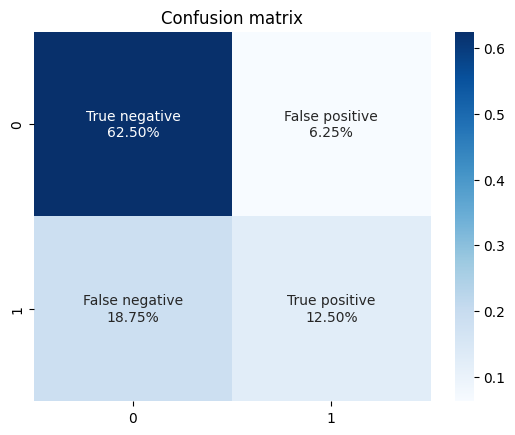

In [33]:
y_true = np.array(y_true)
y_pred = indices.cpu().detach().numpy()

# Accuracy
print(f'Accuracy: {accuracy_score(y_true, y_pred)}')

# F1 score
print(f'F1-score: {f1_score(y_true, y_pred)}')

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='all')
cm_labels = [f'{label}\n{"{0:.2f}%".format(val * 100)}' for label, val in zip(['True negative', 'False positive', 'False negative', 'True positive'], cm.flatten())]
cm_labels = np.asarray(cm_labels).reshape(2, 2)
sns.heatmap(cm, annot=cm_labels, fmt='', cmap='Blues').set(title='Confusion matrix')
plt.show()

## Generating explanations

Generate explanations for all test examples for each interested methods.

In [34]:
def get_explanations(xai_methods_dict, methods, ds_loader, indices, gpu_device):
    explanations = {}
    indices = indices.to(gpu_device)
    
    for method in methods:
        explanations[method] = []

    for method in methods:
        for i, data in enumerate(ds_loader):
            batch = data[0]
            batch_size = batch.shape[0]
            explanation = get_explanation(xai_methods_dict[method], batch.to(gpu_device), indices[i * batch_size:(i + 1) * batch_size])
            explanation = explanation.cpu().detach()
            explanations[method].append(explanation)
    
    return explanations

Gradient-based methods.

In [35]:
%%time
gradient_methods = ['Saliency', 'LRP', 'GradientShap', 'GuidedGradCam', 'GuidedBackprop']
gradient_explanations = get_explanations(xai_methods, gradient_methods, loader, indices, device)

CPU times: user 1.55 s, sys: 149 ms, total: 1.7 s
Wall time: 1.43 s


Perturbation-based methods.

In [36]:
%%time
perturbation_methods = ['IntegratedGradients']
perturbation_explanations = get_explanations(xai_methods, perturbation_methods, loader, indices, device)

CPU times: user 12.2 s, sys: 370 ms, total: 12.6 s
Wall time: 9.19 s


Concatenate explanations of each method into a single tensor.

In [37]:
explanations = {**gradient_explanations, **perturbation_explanations}
methods = gradient_methods + perturbation_methods
for method in methods:
    exp = explanations[method]
    for i in range(len(exp)):
        exp[i] = exp[i].cpu().detach()
    explanations[method] = torch.cat(exp)

## Visualization

Compute average disagreement for a given metric.

In [38]:
def compute_heatmap(methods, explanations, metric, **options):
    size = len(methods)
    result = np.empty((size, size))

    for j in range(size):
        for i in range(size):
            exp1 = explanations[methods[i]]
            exp2 = explanations[methods[j]]
            
            if isinstance(exp1, torch.Tensor):
                exp1 = exp1.cpu().numpy()
            
            if isinstance(exp2, torch.Tensor):
                exp2 = exp2.cpu().numpy()
            
            if i >= j:
                result[i, j] = compute_mean_disagreement(exp1, exp2, metric, **options)
            else:
                result[i, j] = result[j, i]
    return result

In [39]:
def visualize(hm, title):
    return sns.heatmap(hm, annot=True, xticklabels=methods, yticklabels=methods, cmap='Blues').set(title=title)

### Feature Agreement

In [40]:
%%time
heatmap_fa = compute_heatmap(methods, explanations, metric=feature_agreement)

CPU times: user 560 ms, sys: 0 ns, total: 560 ms
Wall time: 567 ms


[Text(0.5, 1.0, 'Feature Agreement')]

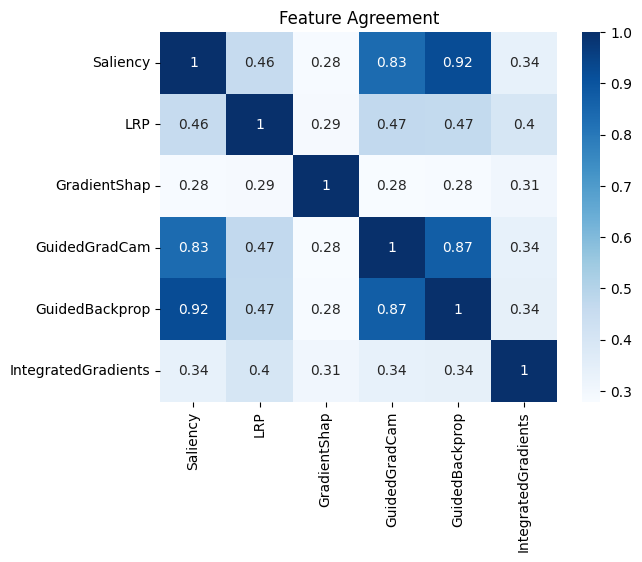

In [41]:
visualize(heatmap_fa, title='Feature Agreement')

### Sign agreements

In [42]:
%%time
heatmap_sa = compute_heatmap(methods, explanations, metric=sign_agreement)

CPU times: user 1.4 s, sys: 528 µs, total: 1.4 s
Wall time: 1.4 s


[Text(0.5, 1.0, 'Sign Agreement')]

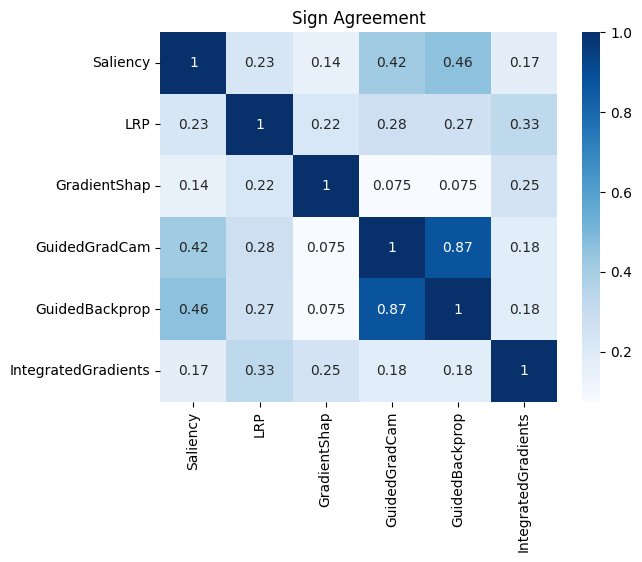

In [43]:
visualize(heatmap_sa, title='Sign Agreement')

### Rank correlation

In [44]:
im_masks = im_masks.flatten(1).bool()

In [45]:
explanations_masked = dict()

for method in methods:
    exp = explanations[method]
    
    masked_list = []
    for i, e in enumerate(exp):
        mask = im_masks[i]
        if mask.sum() == 0:
            continue
        masked = e.flatten()[mask]
        masked_list.append(masked)
    
    explanations_masked[method] = masked_list

In [46]:
%%time
heatmap_rc = compute_heatmap(methods, explanations_masked, metric=rank_correlation)

CPU times: user 96.9 ms, sys: 51 µs, total: 97 ms
Wall time: 98.3 ms


[Text(0.5, 1.0, 'Rank Correlation with Masks')]

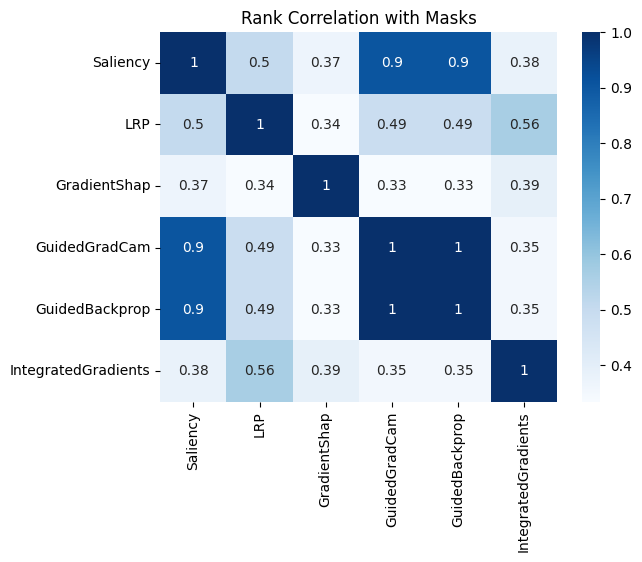

In [47]:
visualize(heatmap_rc, title='Rank Correlation with Masks')

### IoU

In [48]:
%%time
heatmap_iou = compute_heatmap(methods, explanations, metric=positive_iou)

CPU times: user 21.8 ms, sys: 0 ns, total: 21.8 ms
Wall time: 21.9 ms


[Text(0.5, 1.0, 'IoU')]

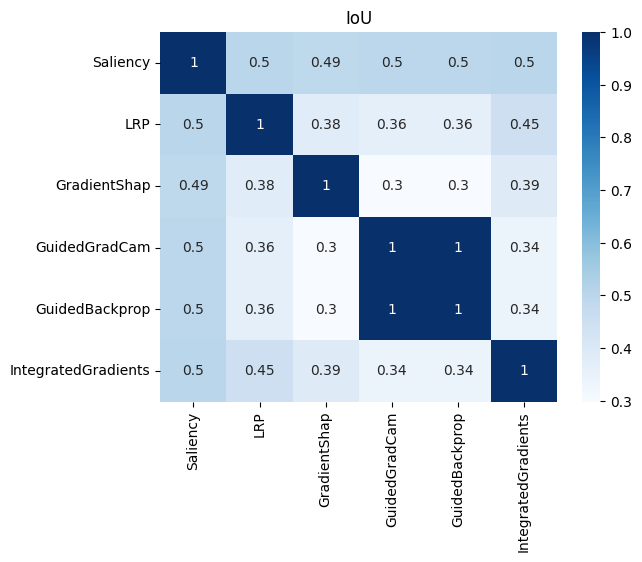

In [49]:
visualize(heatmap_iou, title='IoU')

### SSIM

In [50]:
%%time
heatmap_ssim = compute_heatmap(methods, explanations, metric=ssim)

CPU times: user 555 ms, sys: 1.96 ms, total: 557 ms
Wall time: 563 ms


[Text(0.5, 1.0, 'Structural Similarity Index')]

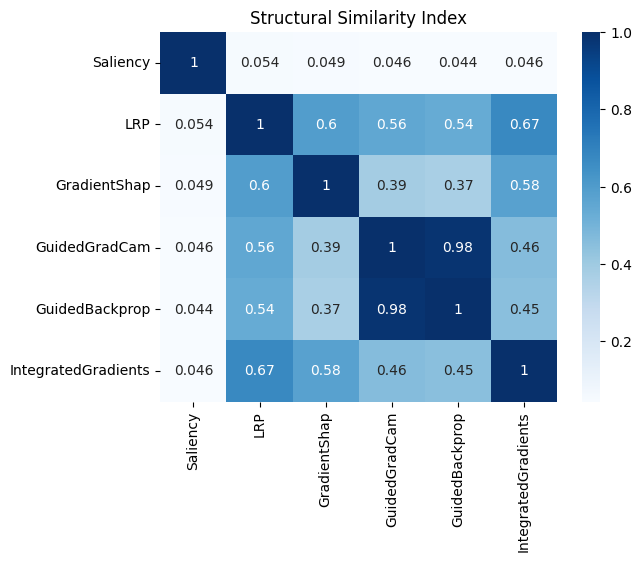

In [51]:
visualize(heatmap_ssim, 'Structural Similarity Index')